# Анализ интернет-магазина: приоритезация гипотез и A/B-тест

## Описание проекта
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

### Описание данных
**Данные для первой части**

Файл /datasets/hypothesis.csv:
- **Hypothesis** — краткое описание гипотезы;
- **Reach** — охват пользователей по 10-балльной шкале;
- **Impact** — влияние на пользователей по 10-балльной шкале;
- **Confidence** — уверенность в гипотезе по 10-балльной шкале;
- **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл /datasets/orders.csv:
- **transactionId** — идентификатор заказа;
- **visitorId** — идентификатор пользователя, совершившего заказ;
- **date** — дата, когда был совершён заказ;
- **revenue** — выручка заказа;
- **group** — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv:
- **date** — дата;
- **group** — группа A/B-теста;
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

### Подготовка данных

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt

In [ ]:
# подгрузим датасеты, проверим их на наличие пропусков и соответствие типам данных
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()
display(hypothesis.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [ ]:
orders = pd.read_csv('/datasets/orders.csv')
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()
display(orders.head())


Начальная дата 2019-08-01, конечная дата 2019-08-31

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [ ]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()
display(visitors.head())


Начальная дата 2019-08-01, конечная дата 2019-08-31

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Приоритезация гипотез

In [ ]:
# метод ICE
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending =False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Наиболее перспективные гипотезы 8, 0, 7.

In [ ]:
# метод RICE
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending =False))

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Здесь уже видим другую картину: наиболее перспективные гипотезы 7, 2, 0.

Результаты отличаются, так как в случае ICE не учитывается охват изменений. Для нашего анализа это важная составляющая оценки гипотез, поэтому наиболее приоритетными гипотезами будут 7, 2, 0.

## Анализ A/B-теста

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


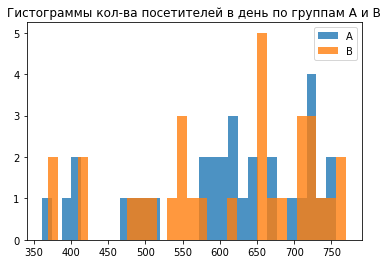

P-value:0.7301376549390499
Разница в количестве посетителей в группах A и B статистически НЕ значима

Начальная конверсия: 0.030
Полученная после изменений конверсия: 0.034
Относительное изменение конверсии после изменений: 0.121


In [ ]:
# проверим корректность распределения на группы A/B

print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))

plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.8, label='A', bins = 30)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.8, label='B', bins = 30)
plt.legend()
plt.title('Гистограммы кол-ва посетителей в день по группам A и B')
plt.show()

results = stats.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

initial_conversion = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
resulting_conversion = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()

print('Начальная конверсия: {:.3f}'.format(initial_conversion))
print('Полученная после изменений конверсия: {:.3f}'.format(resulting_conversion))
print('Относительное изменение конверсии после изменений: {:.3f}'.format(abs(1-(initial_conversion/resulting_conversion))))

Проверим в калькуляторе https://www.evanmiller.org/ab-testing/sample-size.html необходимое количество выборки для корректного проведения теста. Для этого вводим вводим в калькулятор начальную конверсию и относительное изменение конверсии и получаем, что необходимое количество выборки должно быть **35855**. У нас же количество **37652**. Это означает, что количество выборки для A/B-теста подобрано корректно, и статистически значимой разницы в количестве посещений между группами не обнаружено.

### Кумулятивные метрики

In [ ]:
#достаем уникальные значения дат и групп
datesGroups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])

#выводим кумулятивные показатели из orders
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'], x['group']==orders['group'])]\
.agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis = 1)
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

#выводим кумулятивные показатели из visitors
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(x['date'] >= visitors['date'], x['group']==visitors['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)

#сводим все накопительные данные в одну таблицу
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
display(cummulativeData.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


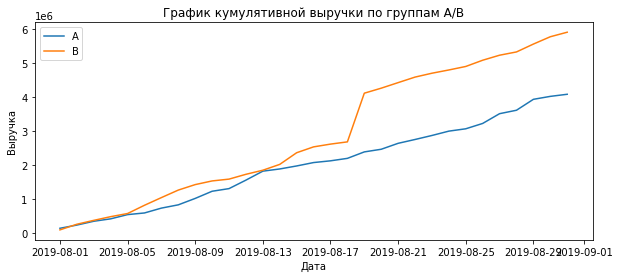

In [ ]:
# визуализируем

cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']

plt.figure(figsize=(10,4))
plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue'], label = 'A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('График кумулятивной выручки по группам A/B')
plt.legend()
plt.show()

По графику видно, что группа B стабильно показывает большую выручку чем группа A.

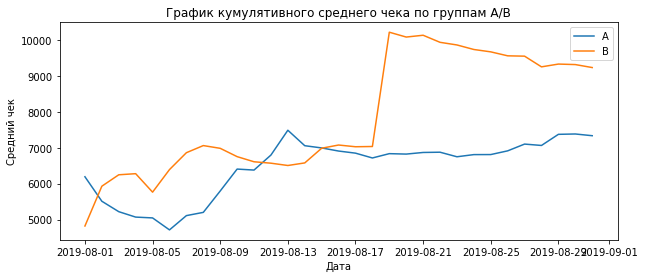

In [ ]:
# построим график кумулятивного среднего чека по группам

plt.figure(figsize=(10,4))
plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue']/cummulativeDataA['orders'], label = 'A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue']/cummulativeDataB['orders'], label = 'B')
plt.title('График кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show()

Средний чек в группе B почти всё время был выше, чем в группе A. Однако есть резкий скачок в середине графика, который может быть обусловлен аномалиями.

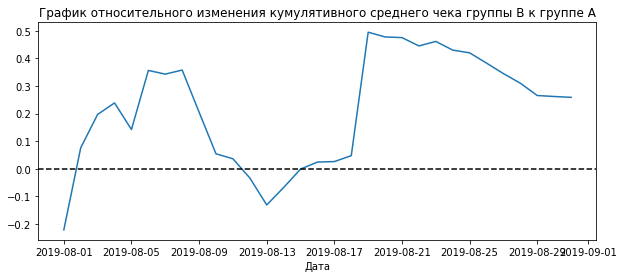

In [ ]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A

mergedCummulativeData = cummulativeDataA.merge(cummulativeDataB, left_on='date', right_on='date', suffixes=['A', 'B'])

plt.figure(figsize=(10,4))
plt.plot(mergedCummulativeData['date'], ((mergedCummulativeData['revenueB']/mergedCummulativeData['ordersB'])/
                                       (mergedCummulativeData['revenueA']/mergedCummulativeData['ordersA'])-1))
plt.axhline(y=0, color='black', linestyle = '--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.show()

Колебания слишком резкие, необходимо проверить данные на наличие аномальных пользователей.

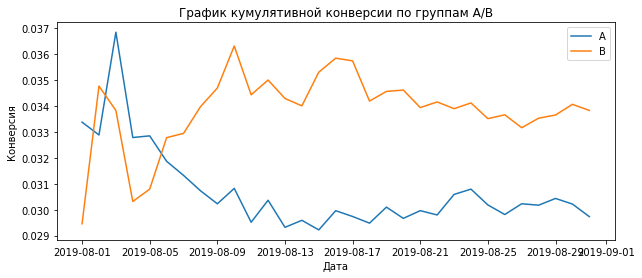

In [ ]:
# построим график кумулятивной конверсии по группам

mergedCummulativeData['conversionA'] =  mergedCummulativeData['ordersA'] / mergedCummulativeData['visitorsA'] 
mergedCummulativeData['conversionB'] =  mergedCummulativeData['ordersB'] / mergedCummulativeData['visitorsB']

plt.figure(figsize=(10,4))
plt.plot(mergedCummulativeData['date'], mergedCummulativeData['conversionA'], label='A')
plt.plot(mergedCummulativeData['date'], mergedCummulativeData['conversionB'], label='B')
plt.title('График кумулятивной конверсии по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()

У группы B стабильно конверсия лучше, чем у группы A.

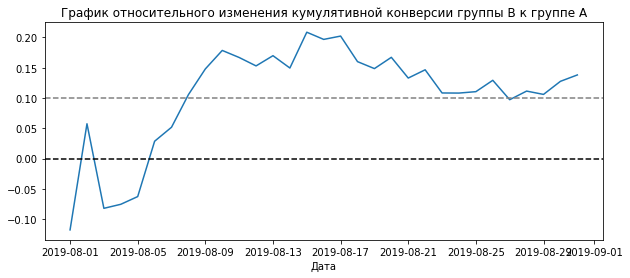

In [ ]:
# построим график относительного изменения кумулятивной конверсии группы B к группе A

plt.figure(figsize=(10,4))
plt.plot(mergedCummulativeData['date'], ((mergedCummulativeData['conversionB']/mergedCummulativeData['conversionA'])-1))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.show()

Конверсия группы B стабильно лучше конверсии группы A на 10% по просшествии 1 недели после начала.

### Статистическая значимость различий

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


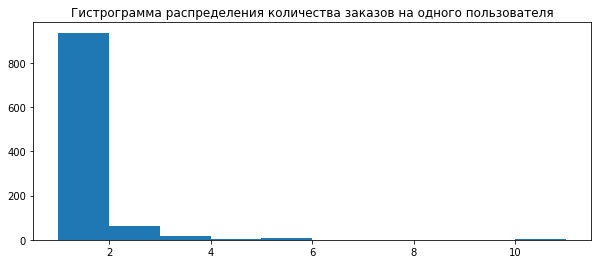

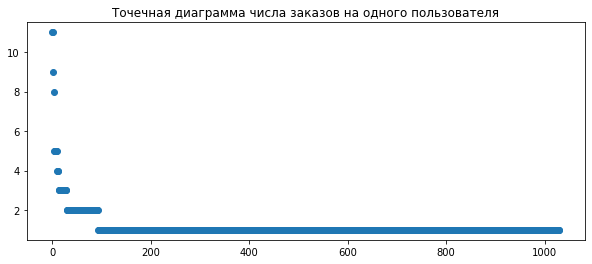

In [ ]:
# построим точечный график количества заказов по пользователям

ordersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending = False)
ordersByUsers.columns = ['visitorId', 'orders']
display(ordersByUsers.head())

plt.figure(figsize=(10,4))
plt.hist(ordersByUsers['orders'], bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(10,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()

По графикам видно, что большая часть пользователей совершает не больше 2 заказов.

In [ ]:
# посчитаем 95-й и 99-й перцентили количества заказов на пользователя, чтобы найти границу для определения аномальных пользователей

print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Больше двух заказов совершают только 5% пользователей.

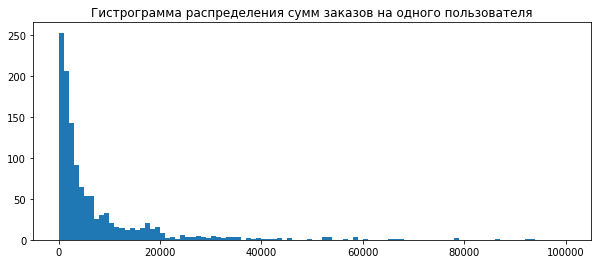

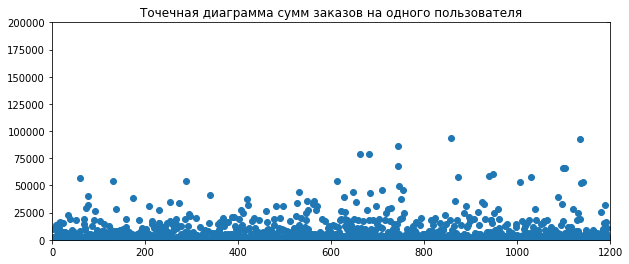

In [ ]:
# построим точечный график стоимостей заказов

plt.figure(figsize=(10,4))
plt.hist(orders['revenue'], range=(0,100000), bins = 100)
plt.title('Гистрограмма распределения сумм заказов на одного пользователя')
plt.show()

x_values = pd.Series(range(0, len(orders)))

plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.show()

На графиках видно, что большая часть пользователей делает покупки суммой не больше 25-30 тысяч рублей.

In [ ]:
# посчитаем 95-й и 99-й перцентили сумм заказов на пользователя и выберем границу для определения аномальных пользователей

print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Только 5% пользователей совершают покупку стоимостью свыше 28 000 рублей.

Зафиксируем границы, по которым дальше отбросим аномальные значения:
- пользователи, совершившие более 3 заказов;
- пользователи, совершившие покупку дороже 35 000 рублей.

Посчитаем статистическую значимость различий в конверсии и среднем чеке заказа между группами по **сырым** данным:

In [ ]:
# датафрейм с посетителями по дням в группе А
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# соберём кумулятивные по дням данные о количестве пользователей в группе A
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 
                                                                                                               'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# датафрейм с посетителями по дням в группе В
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# cоберём кумулятивные по дням данные о количестве пользователей в группе В
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 
                                                                                                               'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# соберем данные о количестве заказов, суммарной выручке по дням в группе А
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# соберем данные о суммарном количестве заказов, суммарной выручке по дням в группе А
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

# соберем данные о количестве заказов, суммарной выручке по дням в группе В
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# соберем данные о суммерном (коммулятивном) количестве заказов, суммарной выручке по дням в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# объеденим полученные данные в один датафрейм
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [ ]:
# создадим переменные ordersByUsersA и ordersByUsersB со столбцами, в которых для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

In [ ]:
# объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [ ]:
# выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Проверим гипотезы на конверсии:
- **Нулевая гипотеза** - по сырым данным конверсия группы A НЕ превышает конверсию группы B;
- **Альтернативная гипотеза** - по сырым данным конверсия группы A превышает конверсию группы B.

In [ ]:
print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("Относительный прирост конверсии группы B по отношению к конверсии группы А по очищенным данным: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

Значение p-value: 0.017
Относительный прирост конверсии группы B по отношению к конверсии группы А по очищенным данным: 0.138


P-value < 0.05: нулевую гипотезу отвергаем, и в конверсии между группами есть статистически значимые различия. 

Относительный прирост конверсии группы B равен 13.8%

Проверим гипотезы на среднем чеке:
- **Нулевая гипотеза** - по сырым данным средний чек группы A НЕ превышает средний чек группы B;
- **Альтернативная гипотеза** - по сырым данным средний чек группы A превышает средний чек группы B.

In [ ]:
# найдём относительные различия в среднем чеке между группами

print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Относительный прирост среднего чека группы B по отношению к среднему чеку группы А по сырым данным: {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Значение p-value: 0.729
Относительный прирост среднего чека группы B по отношению к среднему чеку группы А по сырым данным: 0.259


P-value > 0.05: статистически значимых различий в среднем чеке между группами нет, но различие среднего чека между сегментами 25.9%. Нулевую гипотезу принимаем.

Посчитаем статистическую значимость различий в конверсии и среднем чеке заказа между группами по **очищенным** данным. Отбросим все аномальные значения:
- пользователей, совершивших более 3 заказов;
- пользователей, совершивших покупку дороже 35 000 рублей.

In [ ]:
# узнаем количество аномальных пользователей

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 35000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head())
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
dtype: int64

42


Всего 42 аномальных пользователя.
Узнаем, как их действия повлияли на результаты теста.

Проверим гипотезы на конверсии:
- **Нулевая гипотеза** - по очищенным данным конверсия группы A НЕ превышает коверсию группы B;
- **Альтернативная гипотеза** - по очищенным данным конверсия группы A превышает конверсию группы B.

In [ ]:
# конверсия

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

# применим статистический критерий Манна-Уитни к полученным выборкам
print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительный прирост конверсии группы B по отношению к конверсии группы А по очищенным данным: {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Значение p-value: 0.014
Относительный прирост конверсии группы B по отношению к конверсии группы А по очищенным данным: 0.155


Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент В значительно лучше сегмента А. Нулевую гипотезу отвергаем.

Проверим гипотезы на среднем чеке:
- **Нулевая гипотеза** - по очищенным данным средний чек группы A НЕ превышает средний чек группы B;
- **Альтернативная гипотеза** - по очищенным данным средний чек группы A превышает средний чек группы B.

In [ ]:
# средний чек

print("Значение p-value: {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("Относительный прирост среднего чека группы B по отношению к среднему чеку группы А по очищенным данным: {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

Значение p-value: 0.874
Относительный прирост среднего чека группы B по отношению к среднему чеку группы А по очищенным данным: 0.025


P-value увеличился, разница между сегментами сократилась с 25.9% до 2.5%. Статистически значимых различий в среднем чеке между группыми нет. Нулевую гипотезу принимаем.

## Общий вывод

1. С самого начала выручка увеличивалась почти равномерно, но с 2019-08-17 группы В начала очень резко расти.
2. Конверсия группы В почти сразу стала выше и зафиксировалась с небольшими колебаниями, а группа А просела и так же зафиксировалась.
3. Не более 5% пользователей оформляли больше чем 2 заказа. И 1% пользователей заказывали более четырёх раз.
4. Большая часть пользователей совершала заказы стоимость до 40 000 рублей, но есть и аномально дорогие заказы, например, стоимостью 60 000, 80 000 и 90 000 рублей.
5. Статистическая значимость достигнута. Сегмент В значительно лучше сегмента А. После сравнения по среднему чеку р-value увеличился, но и разница между сегментами сократилась с 25.9% до 2.5%.

Исходя их обнаруженных фактов, тест следует остановить и признать его успешным.